## 프로젝트02
- 프로젝트01과 같음
  - 프로젝트01이 전처리, logistic까지였으나 사실상 모델링도 수행해 봄
  - 데이터는 kaggle에 나오는 LoanDefault 데이터
  - https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data
  - kaggle에서 해당 데이터 출처 확인했으나, 본 수업에서는 이미 csv파일이 제공
- 여기서는 (편의상) EDA 부분은 jupyterlab에서 interactive하게 진행
  - 전 주에 수행한 부분 복습/확인
- 전처리하고, train/test set 나누는 부분까지 class 적용  
- torch로도 연습해 보는 것이 좋지만, (향후) 딥러닝 모델 연습 때 주로 활용 예정
  - 이번 프로젝트에서는 sklearn으로 실습 진행
- under(over) sampling 적용해보기
  - train_test_split 이후에 적용


### 01 Library & HyperParameter Defintion

#### 01-01) 데이터, 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # scaling 방법 import
from sklearn.model_selection import train_test_split # train_test_split import
from sklearn.linear_model import LogisticRegression # 로지스틱 모형 불러오기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 평가지표(accuracy, precision, recall, f1_score)
import matplotlib.pyplot as plt # 시각화 라이브러리-1
import seaborn as sns # 시각화 라이브러리-2

# 컬럼명 처리 관련 라이브러리 및 함수정의(XG-boost 때문)
import re
def clean_feature_names(columns):
    return [re.sub(r"[<>\[\]]", "_", col) for col in columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_path = '/content/drive/MyDrive/AI_serivce_track/Week_01'

# 정확한 이름으로 다시 할당
data_path = os.path.join(base_path, 'Loan_Default.csv')
Loan_Default_df = pd.read_csv(data_path)
Loan_Default_df.shape

(148670, 34)

#### 01-02) hyper-parameter 정의

In [ ]:
# hyper-parameter definition

# 변수 선택 및 train/test 비율 관련
target_var = 'Status' # y에 해당하는 변수
delete_var = ['ID','year','credit_type_EQUI'] # 불필요한 변수
# credit_type_EQUI에 의해 완전히 변수가 분리되어서 random-forest 모든 성능지표가 1을 찍음
test_rate = 0.2 # test 데이터셋 비율
random_state = 42 # random_state 지정 (train_test_split에 활용)

# 전처리 Class 관련 hyper-parameter
missing_value_rate = 0.01 # 1% 이상이면 범주/수치 상관없이 해당 값 삭제
skewness_abs_criterion = 2 # skewness 절대값이 2 넘어가면(결측치가 missing_value_rate 이상이고), log1p변환 후 impute!
scaling_method = 'standard' # ('standard','min_max','robust','None' 중 입력) # None으로 입력하나 scaling_method 지우나 결과는 같음

### 02 EDA + Sampling
- 수업 과정에서 제시된 것과 달리, EDA나 sampling 과정은 유동적일 수 있으므로
  class로 정의해서, 진행하지는 않음
  - missing value가 어느 정도 비율(예: 1%)이면 무시하고 삭제할지
  - missing value가 (1% 이상이고) 범주형이라면?
    - 'Unknown'이나 'Missing'으로 채우고 나중에 one-hot-encoding

#### 02-01 데이터 살펴보기

In [ ]:
Loan_Default_df.info() # 148670이 전체 크기, missing_value가 많

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
# 결측치 비율 확인
Loan_Default_df.isnull().mean()

,0
ID,0.000000
year,0.000000
loan_limit,0.022493
Gender,0.000000
approv_in_adv,0.006107
loan_type,0.000000
loan_purpose,0.000901
Credit_Worthiness,0.000000
open_credit,0.000000
business_or_commercial,0.000000


In [ ]:
Loan_Default_df.head(n=3) # 원래 기본값이 n=5 임

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0


In [ ]:
# 결측치 비율, 데이터타입 결합

null_ratio = Loan_Default_df.isnull().mean() # 결측치 비율
dtypes = Loan_Default_df.dtypes

# 데이터프레임으로 병합
summary = pd.DataFrame({
    'missing_ratio': null_ratio,
    'dtype': dtypes
})

# 비율 내림차순 정렬 (선택)
summary = summary.sort_values(by='missing_ratio', ascending=False)

summary.head(10)  # 상위 10개만 보기

,missing_ratio,dtype
Upfront_charges,0.266644,float64
Interest_rate_spread,0.246445,float64
rate_of_interest,0.245100,float64
dtir1,0.162245,float64
property_value,0.101554,float64
LTV,0.101554,float64
income,0.061546,float64
loan_limit,0.022493,object
approv_in_adv,0.006107,object
age,0.001345,object


#### 02-02 데이터시각화

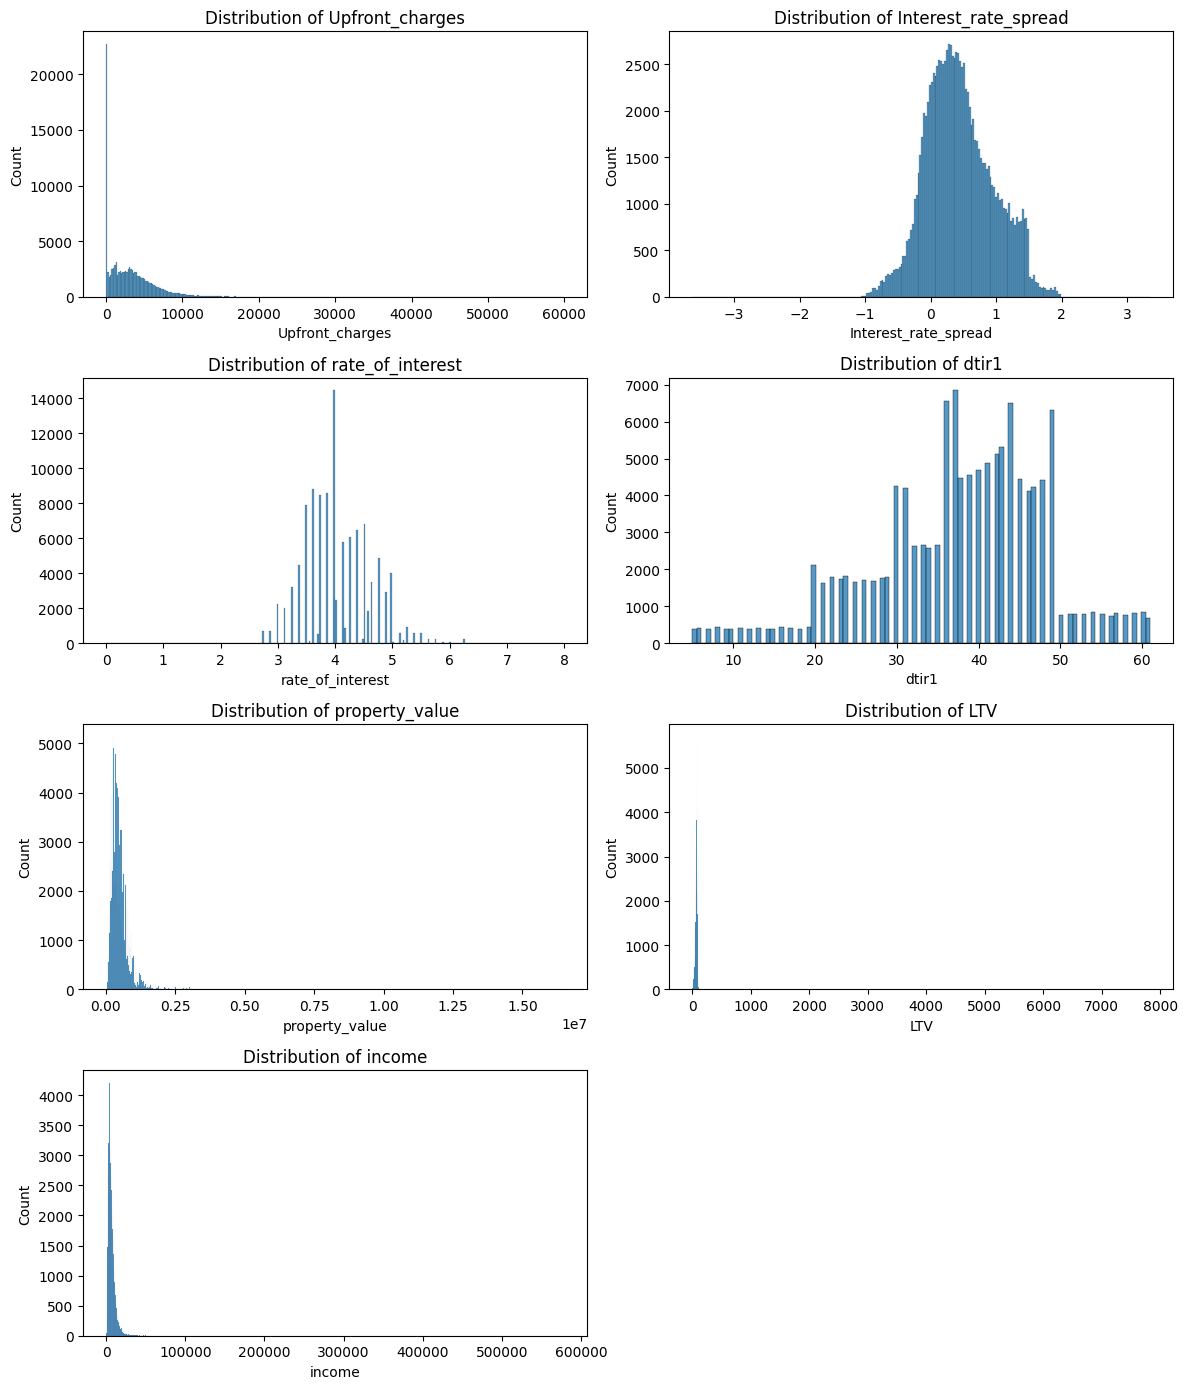

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형/결측치 많은 7개 체크
col_list = ['Upfront_charges','Interest_rate_spread','rate_of_interest','dtir1','property_value','LTV','income']

# subplot 설정 (4행 2열)
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.flatten()  # 2D -> 1D array

# 각 컬럼별 히스토그램 그리기
for i, col in enumerate(col_list):
    sns.histplot(Loan_Default_df[col], ax=axes[i], kde=False)
    axes[i].set_title(f"Distribution of {col}")

# 빈 subplot 지우기 (마지막 칸)
for j in range(len(col_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Upfront_charges, property_value, LTV, income -> 심하게 기울어져 있으므로 log변환(log1p) 해서 missing-value채우기
# Interest_rate_spread, rate_of_interest, dtir1 -> 중간값으로 채워도 될 듯

In [ ]:
# (참고) 클래스 전처리 로직 확립 목적으로 수치형 컬럼 skewness계산
# 수치형 컬럼만 추출
num_cols = Loan_Default_df.select_dtypes(include=['float64', 'int64']).columns
# skewness 계산
skew_vals = Loan_Default_df[num_cols].skew()

# 보기 좋게 정리 (절댓값 내림차순 정렬)
skew_summary = skew_vals.abs().sort_values(ascending=False).to_frame(name='abs_skew')

# 원래 skewness 값도 같이 보기
skew_summary['skew'] = skew_vals[skew_summary.index]

skew_summary

,abs_skew,skew
LTV,120.615337,120.615337
income,17.307695,17.307695
property_value,4.586276,4.586276
term,2.174822,-2.174822
Upfront_charges,1.754076,1.754076
loan_amount,1.666998,1.666998
Status,1.176762,1.176762
dtir1,0.551465,-0.551465
rate_of_interest,0.388406,0.388406
Interest_rate_spread,0.280762,0.280762


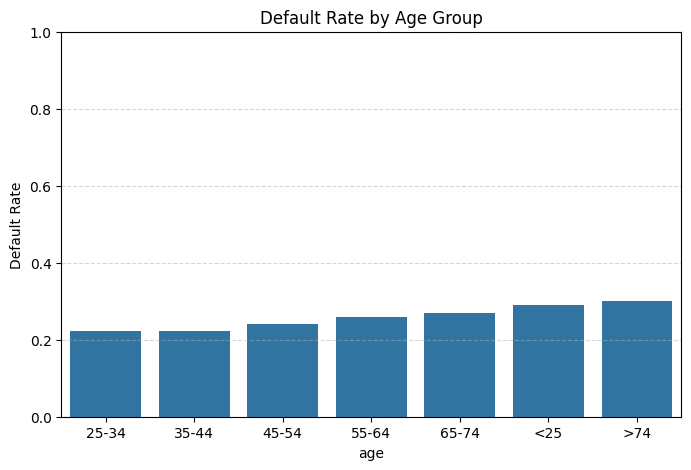

In [ ]:
# age가 올라갈수록, 파산 확률도 올라가는 경향 존재
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 교차표로 default 비율 계산
age_default_rate = pd.crosstab(Loan_Default_df['age'], Loan_Default_df['Status'], normalize='index')[1]

# 시리즈 → DataFrame 변환
age_default_rate = age_default_rate.reset_index().rename(columns={1: 'default_rate'})

# 막대그래프 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=age_default_rate, x='age', y='default_rate', order=sorted(age_default_rate['age']))
plt.ylabel("Default Rate")
plt.title("Default Rate by Age Group")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 03 Data-Preprocessing

#### 03-01 전처리 클래스 정의 및 적용
- 전처리 클래스 정의?
  - 불필요 컬럼 삭제
  - 결측치 비율, 데이터 타입 따른 전처리 로직
    - 결측치(1%)미만, 수치형 -> 제거
    - 결측치(1%)미만, 범주형 -> 제거
    - 결측치(1%)이상, 수치형 -> 중간값 또는 skewness심하면 log1p 변환
    - 결측치(1%)이상, 범주형 -> 'Unknown'이나 'Missing'으로 처리

In [ ]:
class DataPreprocessor:
  def __init__(self,target_var,delete_var=None, test_rate=0.2, random_state=42,
               missing_value_rate=0.01, skewness_abs_criterion=2, log_transform_cols=None,scaling_method=None):
    # class 정의할 때 test_rate=0.2 처럼 초기값을 입력해줘야함
    # 외부에서 정한 값을 직접 참조하는 구조가 아님
    self.target_var = target_var
    self.delete_var = delete_var if delete_var else []
    self.test_rate = test_rate
    self.random_state = random_state
    self.missing_value_rate = missing_value_rate
    self.skewness_abs_criterion = skewness_abs_criterion
    self.log_transform_cols = log_transform_cols if log_transform_cols is not None else []
    self.scaling_method = scaling_method.lower() if scaling_method else None

  def fit_transform(self, df):
    # fit_transform이라는 매서드 정의
    df = df.copy() # pandas warning방지 차원에서 .copy()

    # 1. Drop delete_vars, 불필요한 컬럼 제거
    df.drop(columns = self.delete_var, inplace = True, errors = 'ignore')

    # 2. Separate target
    y = df[self.target_var]  # 수정됨
    df.drop(columns=[self.target_var], inplace=True)  # 수정됨

    # 3. Column type 나누기(수치형, 범주형)
    num_cols = df.select_dtypes(include = ['float64','int64']).columns
    cat_cols = df.select_dtypes(include = ['object']).columns

    # 4. log1p 대상 자동 판단 (없으면)
    if not self.log_transform_cols:
      skewed = df[num_cols].skew().abs()
      self.log_transform_cols = skewed[skewed > self.skewness_abs_criterion].index.tolist()

    # 5. 결측 비율 기준 행 제거
    missing_ratio = df.isnull().mean()
    cols_to_dropna = missing_ratio[missing_ratio < self.missing_value_rate].index.tolist()
    df.dropna(subset=cols_to_dropna, inplace=True)  # 수정됨
    y = y.loc[df.index]  # 수정됨: row 삭제 후 target 재정렬

    # 6. 남은 결측치 처리
    for col in df.columns:
      if col in num_cols:
        if col in self.log_transform_cols:
          df[col] = df[col].clip(lower=0)  # 수정됨: 음수 방지
          df[col] = np.log1p(df[col])
        df[col] = df[col].fillna(df[col].median())
      elif col in cat_cols:
        df[col] = df[col].fillna("Missing_value")

    # 7. 범주형 변수 One-Hot 인코딩
    df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
    df_num = df[num_cols]

    # 8. Scaling 선택적
    if self.scaling_method:
      if self.scaling_method=='standard':
        scaler = StandardScaler()
      elif self.scaling_method=='min_max':
        scaler = MinMaxScaler()
      elif self.scaling_method=='robust':
        scaler = RobustScaler()
      else:
        raise ValueError("Unsupported scaling_method. Choose from 'standard', 'min_max', 'robust', or None.")

    # 9. 피처 조합
    X = pd.concat([df_num, df_cat], axis=1) # y는 앞에서 정의함

    # 🔧 컬럼 이름 정제(xg-boost feature문제 때)
    X.columns = clean_feature_names(X.columns)

    # 10. train-test split
    return train_test_split(X, y, test_size=self.test_rate,
                            random_state=self.random_state, stratify=y)


In [ ]:
prep = DataPreprocessor(
    target_var='Status',
    delete_var=['ID', 'year','credit_type_EQUI','Interest_rate_spread','Upfront_charges','Secured_by','Security_Type'],
    test_rate=0.2,
    random_state=42,
    missing_value_rate=0.01,
    skewness_abs_criterion=2,
    scaling_method = 'standard'
)
## Random-Forest 성능지표가 모두 1을 찍어서 변수 조정

## 아래 변수들은 사실상 모형에 정답을 알려주는 변수(over-fitting문제)
# credit_type_EQUI	target이 1일 때만 등장
# Interest_rate_spread	값 하나로 거의 이진 분리 가능
# Upfront_charges	희귀값에서 완전분리 다수
# Secured_by	"land" → 모두 불량 (Status=1), 심각한 규칙성
# Security_Type	"Indriect"일 경우 모두 default

# 위 다섯 변수가 다 들어가 있는 경우 모든 성능지표가 1을 찍음

X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [ ]:
X_train, X_test, y_train, y_test = prep.fit_transform(Loan_Default_df)

In [ ]:
print(f'train데이터 수: {X_train.shape[0]}')
print(f'test데이터 수: {X_test.shape[0]}')

train데이터 수: 117819
test데이터 수: 29455


In [ ]:
print(f'train에서 1의 비율: {round(y_train.sum()/len(y_train),4)}')
print(f'test에서 1의 비율: {round(y_test.sum()/len(y_test),4)}') # 사실 이 정도 imbalance면 굳이 over/under sampling고민 하지 않아도 될 듯!

train에서 1의 비율: 0.2453
test에서 1의 비율: 0.2453


### 04 Under(Over) sampling
- Undersampling: 다수 클래스의 샘플을 줄여 클래스 간 균형을 맞추는 방식
- Oversampling: 소수 클래스의 샘플을 늘려 클래스 간 균형을 맞추는 방식 (ex. SMOTE)
- 강의 자료에서는 데이터 전처리 단계에서 언더/오버샘플링을 수행한다고 소개
  - train/test 분할 이전에 샘플링을 수행하면 심각한 문제 발생
  - train/test split 이전에 샘플링을 수행하면, test 데이터의 일부 정보가 학습 데이터에 반영(Data Leakage)
- 더 나은 절차는 아래와 같음(gpt/gemini)
  - 원본 데이터를 먼저 train/test로 분할
  - train 데이터에만 under/over sampling 적용
  - 모델 학습은 샘플링된 train 데이터를 사용
  - 모델 평가 시에는 샘플링이 적용되지 않은 원래 test 데이터를 사용
- 상기 근거로, 수업 내용에서 가이드 된 것과 다르게 train/test split 이후
  Under(Over)sampling을 수행하고자 함

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# 1. 언더샘플링 객체 생성
rus = RandomUnderSampler(random_state=42)

# 2. 학습 데이터에만 적용
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# 3. 결과 확인
print('Before undersampling:', Counter(y_train))
print('After undersampling:', Counter(y_train_resampled))

Before undersampling: Counter({0: 88920, 1: 28899})
After undersampling: Counter({0: 28899, 1: 28899})


### 05 모델 성능실험
- 로지스틱
  - 그대로 했을 때(iter=2000, 109초)
    - Accuracy : 0.8701
    - Precision : 0.93(positive class=1)
    - Recall : 0.51(positive class=1)
    - F1-score :0.6597(positive class=1)
  - UnderSampling(iter=2000, 76초)
    - Accuracy : 0.8237
    - Precision : 0.63(positive class=1)
    - Recall : 0.67(positive class=1)
    - F1-score :0.6505(positive class=1)
- RandomForest
  - 그대로 했을 때(20.19초)
    - Accuracy : 0.9340
    - Precision : 0.89(positive class=1)
    - Recall : 0.83(positive class=1)
    - F1-score :0.8609(positive class=1)
  - UnderSampling(7.38초)
    - Accuracy : 0.9164
    - Precision : 0.75(positive class=1)
    - Recall : 0.98(positive class=1)
    - F1-score :0.8515(positive class=1)
- GraidentBoosting
  - 그대로 했을 때(35.7초)
    - Accuracy : 0.9301
    - Precision : 0.87(positive class=1)
    - Recall : 0.84(positive class=1)
    - F1-score :0.8557(positive class=1)
  - UnderSampling(13.9초)
    - Accuracy : 0.9012
    - Precision : 0.71(positive class=1)
    - Recall : 1.00(positive class=1)
    - F1-score :0.8323(positive class=1)
- XGBoost
  - 그대로 했을 때(1.76초)
    - Accuracy : 0.9335
    - Precision : 0.87(positive class=1)
    - Recall : 0.86(positive class=1)
    - F1-score :0.8636(positive class=1)
  - UnderSampling
    - Accuracy : 0.9056
    - Precision : 0.72(positive class=1)
    - Recall : 1.00(positive class=1)
    - F1-score :0.8382(positive class=1)

- 시사점
  - 로지스틱 : Undersampling시, precision낮아지고 recall 오름
  - RandomForest, GradientBoosting, XG-boosting도 로지스틱과 같은 경향 보임
  - F1-score가 모든 경우에 있어서 근소하게나마 낮아짐

#### 05-01 평가함수 정의

In [ ]:
# 전제: undersampling 완료된 데이터
# X_train_resampled, y_train_resampled  ← train set (undersampled)
# X_test, y_test                        ← test set (original)

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # pip install xgboost

In [ ]:
import time

def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"모델: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"학습 소요 시간: {train_time:.2f}초")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

#### 05-02 모델 평가

##### 로지스틱

In [ ]:
# Logistic Regression
log_reg_1 = LogisticRegression(max_iter=2000, random_state=42)
evaluate_model(log_reg_1, X_train, y_train, X_test, y_test)

모델: LogisticRegression
Accuracy: 0.8701
F1 Score: 0.6579
학습 소요 시간: 107.41초
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     22230
           1       0.93      0.51      0.66      7225

    accuracy                           0.87     29455
   macro avg       0.90      0.75      0.79     29455
weighted avg       0.88      0.87      0.86     29455

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=2000, random_state=42)
evaluate_model(log_reg, X_train_resampled, y_train_resampled, X_test, y_test)

모델: LogisticRegression
Accuracy: 0.8237
F1 Score: 0.6505
학습 소요 시간: 76.36초
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     22230
           1       0.63      0.67      0.65      7225

    accuracy                           0.82     29455
   macro avg       0.76      0.77      0.77     29455
weighted avg       0.83      0.82      0.83     29455

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### RandomForest

In [ ]:
# Random Forest
rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_1, X_train, y_train, X_test, y_test)

모델: RandomForestClassifier
Accuracy: 0.9340
F1 Score: 0.8609
학습 소요 시간: 27.12초
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22230
           1       0.89      0.83      0.86      7225

    accuracy                           0.93     29455
   macro avg       0.92      0.90      0.91     29455
weighted avg       0.93      0.93      0.93     29455

--------------------------------------------------


In [ ]:
# Random Forest
rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_2, X_train_resampled, y_train_resampled, X_test, y_test)

모델: RandomForestClassifier
Accuracy: 0.9164
F1 Score: 0.8515
학습 소요 시간: 8.53초
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     22230
           1       0.75      0.98      0.85      7225

    accuracy                           0.92     29455
   macro avg       0.87      0.94      0.90     29455
weighted avg       0.93      0.92      0.92     29455

--------------------------------------------------


##### GradientBoosting

In [ ]:
# Gradient Boosting
gb_1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(gb_1, X_train, y_train, X_test, y_test)

모델: GradientBoostingClassifier
Accuracy: 0.9301
F1 Score: 0.8557
학습 소요 시간: 31.04초
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     22230
           1       0.87      0.84      0.86      7225

    accuracy                           0.93     29455
   macro avg       0.91      0.90      0.90     29455
weighted avg       0.93      0.93      0.93     29455

--------------------------------------------------


In [ ]:
# Gradient Boosting
gb_2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model(gb_2, X_train_resampled, y_train_resampled, X_test, y_test)

모델: GradientBoostingClassifier
Accuracy: 0.9012
F1 Score: 0.8323
학습 소요 시간: 13.57초
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     22230
           1       0.71      1.00      0.83      7225

    accuracy                           0.90     29455
   macro avg       0.86      0.93      0.88     29455
weighted avg       0.93      0.90      0.91     29455

--------------------------------------------------


##### XG-boost

In [ ]:
# XGBoost
xgb_1 = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=42)
evaluate_model(xgb_1, X_train, y_train, X_test, y_test)

모델: XGBClassifier
Accuracy: 0.9335
F1 Score: 0.8636
학습 소요 시간: 1.74초
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     22230
           1       0.87      0.86      0.86      7225

    accuracy                           0.93     29455
   macro avg       0.91      0.91      0.91     29455
weighted avg       0.93      0.93      0.93     29455

--------------------------------------------------


In [ ]:
# XGBoost
xgb_2 = XGBClassifier(n_estimators=100, learning_rate=0.1, eval_metric='logloss', random_state=42)
evaluate_model(xgb_2, X_train_resampled, y_train_resampled, X_test, y_test)

모델: XGBClassifier
Accuracy: 0.9056
F1 Score: 0.8382
학습 소요 시간: 6.17초
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     22230
           1       0.72      1.00      0.84      7225

    accuracy                           0.91     29455
   macro avg       0.86      0.94      0.89     29455
weighted avg       0.93      0.91      0.91     29455

--------------------------------------------------
